In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

In [23]:
from tf_unet import image_gen

In [24]:
nx = 256
ny = 256

In [25]:
generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=5)
tf.reset_default_graph()

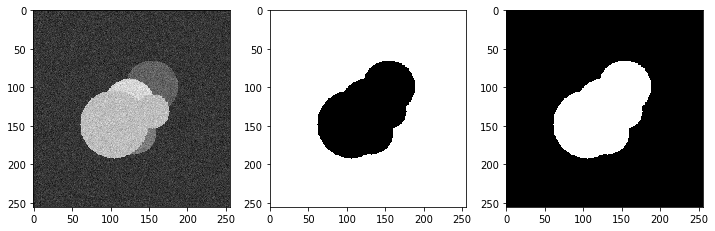

In [26]:
x_test, y_test = generator(1)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(x_test[0,...,0], cmap="gray")
ax[1].imshow(y_test[0,...,0], cmap="gray")
ax[2].imshow(y_test[0,...,1], cmap="gray")

In [27]:
input_x = tf.placeholder(tf.float32, [None, None, None, 1])
input_y = tf.placeholder(tf.float32, [None, None, None, 2])
train= tf.placeholder(tf.bool)

In [28]:
def pool(inputs):
    pooled = tf.layers.max_pooling2d(inputs=inputs, pool_size=[2, 2], strides=2)
    return pooled

In [29]:
def conv2d(input_layer,filter_num,filter_size,drop_rate,padding='valid',train=True):
    
    conv_layer=tf.layers.conv2d(inputs=input_layer,filters=filter_num,kernel_size=filter_size,
                                padding=padding, activation=tf.nn.relu,
                                kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                bias_initializer=tf.constant_initializer(0.1))
    
    return conv_layer

In [30]:
def conv2d_transpose(input_layer,filter_num,filter_size,drop_rate,stride,padding='valid',train=True):
    
    deconv_layer=tf.layers.conv2d_transpose(inputs=input_layer,filters=filter_num,
                                            kernel_size=filter_size,
                                            strides=2,padding=padding, activation=tf.nn.relu)
    
    return deconv_layer

In [31]:
def down_layer(input_layer,filter_num,filter_size,drop_rate,padding='same',train=True):
    
    layer1=conv2d(input_layer,filter_num,filter_size,drop_rate,padding=padding,train=True)
    layer2=conv2d(layer1,filter_num,filter_size,drop_rate,padding=padding,train=True)
    
    return layer2

In [32]:
def up_layer(input_layer,filter_num,filter_size,dropout_rate,padding='same',train=True):
    
    layer1=conv2d(input_layer,filter_num,filter_size,dropout_rate,padding=padding,train=True)
    layer2=conv2d(layer1,filter_num,filter_size,dropout_rate,padding=padding,train=True)
    
    return layer2

In [33]:
def layer_level(previous_layer,filter_num,filter_size,dropout_rate,stride,layer_num,pad='valid',train=True):
    
    if(layer_num>0):
        current_layer_down= down_layer(previous_layer,filter_num,filter_size,dropout_rate,pad,train)
        current_layer =tf.layers.max_pooling2d(inputs=current_layer_down,pool_size=2,strides=2,padding=pad)
        current_layer = layer_level(current_layer,(filter_num*2),filter_size,dropout_rate,stride,(layer_num-1),pad,True)
        current_layer = tf.concat([current_layer_down,current_layer], 3)    
    
    if (layer_num==0): 
        current_layer = up_layer(previous_layer,filter_num,filter_size,dropout_rate,pad,train)
    else:
        current_layer = up_layer(current_layer,filter_num,filter_size,dropout_rate,pad,train)
    
    if(layer_num<4):
        current_layer = conv2d_transpose(current_layer,filter_num//2,filter_size,dropout_rate,stride,pad,True)
       
        
    return current_layer
    

In [34]:
def one_by_one(input_layer,filter_num,filter_size,drop_rate,pad='valid',train=True):
    
    fully_con= tf.layers.conv2d(inputs=input_layer,filters=filter_num,kernel_size=filter_size,
                                padding=pad)
    
    return fully_con

In [35]:
filter_num=16
filter_size=3
dropout_rate=0.0
stride=1
layer_num=4
pad='same'

def my_unet(input_layer):
    
    final= layer_level(input_layer,filter_num,filter_size,dropout_rate,stride,layer_num,pad)
    output= one_by_one(final,2,1,drop_rate=0.0,pad=pad,train=train)
    
    return output

In [36]:
sess = tf.Session()
with tf.variable_scope("net") as scope:
    logits = my_unet(input_x)
    
labels = input_y
flat_logits = tf.reshape(logits, [-1, 2])
flat_labels = tf.reshape(labels, [-1, 2])

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels))

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss=loss)
    
sess.run(tf.global_variables_initializer())

iter loss =  0.68435
iter loss =  0.360754
iter loss =  0.192611
iter loss =  0.0912457
iter loss =  0.0761952


Text(0.5,1,'Logits Output')

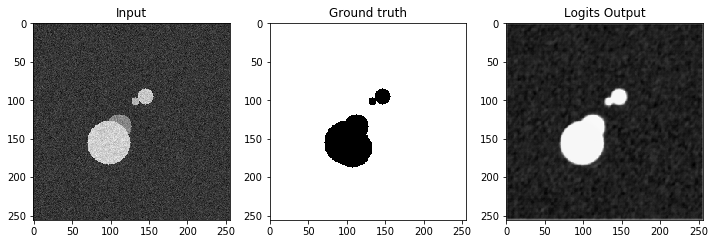

In [37]:
 for step in range(100):
    x_test, y_test = generator(1)
    _, iter_loss = sess.run((optimizer, loss), feed_dict={input_x: x_test,
                                                          input_y: y_test,
                                                          train: "True"})
    if step%20 == 0:
        print("iter loss = ", iter_loss)
x = sess.run(logits, feed_dict={input_x: x_test, 
                                input_y: y_test,
                                train: "False"})
fig, ax= plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(x_test[0,:,:,0], cmap='gray')
ax[1].imshow(y_test[0,:,:,0], cmap='gray')
ax[2].imshow(x[0,:,:,1], cmap='gray')
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Logits Output")

Text(0.5,1,'Prediction')

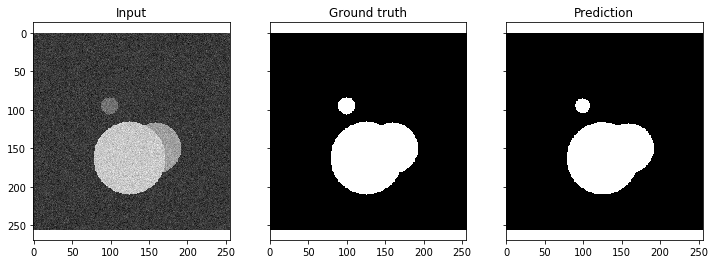

In [38]:
exponential_map = tf.exp(logits)
sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(logits)[3]]))
predicter = tf.div(exponential_map,tensor_sum_exp)

x_test, y_test = generator(1)
prediction = sess.run(predicter, feed_dict={input_x: x_test,
                                            input_y: y_test,
                                            train:False})
mask = prediction[0,:,:,1] > 0.5
fig, ax= plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
ax[0].imshow(x_test[0,:,:,0], cmap='gray')
ax[1].imshow(y_test[0,:,:,1], cmap='gray')
ax[2].imshow(mask, cmap='gray')
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")

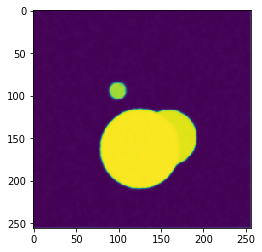

In [39]:
plt.imshow(prediction[0,:,:,1])

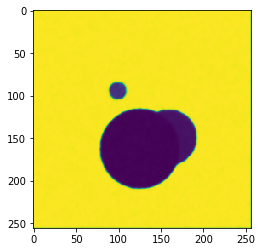

In [40]:
plt.imshow(prediction[0,:,:,0])

In [ ]:
sess.close()